In [1]:
import collections
import numpy as np
import tskit
import sys
sys.path.append("../")
import sc2ts

In [2]:
# Generate these trees by running pytest tests/test_inference.py
ts_file = "../tests/data/cache/2020-02-13.ts"
ts = tskit.load(ts_file)
ts


In [3]:
mut_labels = {}
mut_pos = []
mut_types = []

for mut in ts.mutations():
    site = ts.site(mut.site)
    pos = int(site.position)
    older_mut = mut.parent >= 0
    prev = ts.mutation(mut.parent).derived_state if older_mut else site.ancestral_state
    mut_labels[mut.id] = f"{prev}{pos}{mut.derived_state}"
    mut_pos.append(pos)
    mut_types.append(f"{prev}{mut.derived_state}")


collections.Counter(mut_types)


Counter({'CT': 38,
         'GT': 8,
         'AG': 7,
         'TC': 7,
         'GA': 4,
         'A-': 4,
         'T-': 3,
         'C-': 2,
         'TA': 1,
         'GC': 1,
         'CA': 1,
         'G-': 1})

In [4]:
# There is one site having two mutations.
mut_pos_counts = collections.Counter(mut_pos)
for k, v in mut_pos_counts.items():
    if v > 1:
        print(f"pos: {k}; count: {v}")


pos: 29742; count: 2


In [5]:
# The majority of samples should be from the lineage B, with some from the lineage A.
node_labels = {}
pango_labels = []
for node in ts.nodes():
    if node.is_sample() and "Viridian_pangolin" in node.metadata:
        strain = node.metadata["strain"]
        pango = node.metadata["Viridian_pangolin"]
        node_labels[node.id] = f"{node.id} {pango}\n{strain}"
        pango_labels.append(pango)
    else:
        node_labels[node.id] = f"{node.id}"
collections.Counter(pango_labels)


Counter({'B': 24, 'A': 15, 'B.1': 4, 'B.40': 3, 'B.4': 1, 'B.33': 1})

In [6]:
# Check polytomy at the top.
ts.first().num_children_array


array([ 1, 16,  0,  0,  0,  5,  0,  0,  1, 13,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  4,  0,  0,  0,  0,  0,  2,  0,  0,  0,  0,  2,  0,  0,
        2,  0,  0,  0,  0,  3,  0,  0,  0,  0,  2,  2,  0,  0,  0,  0,  2,
        0,  2,  0,  2,  0,  0,  0,  0,  0,  0,  2,  1], dtype=int32)

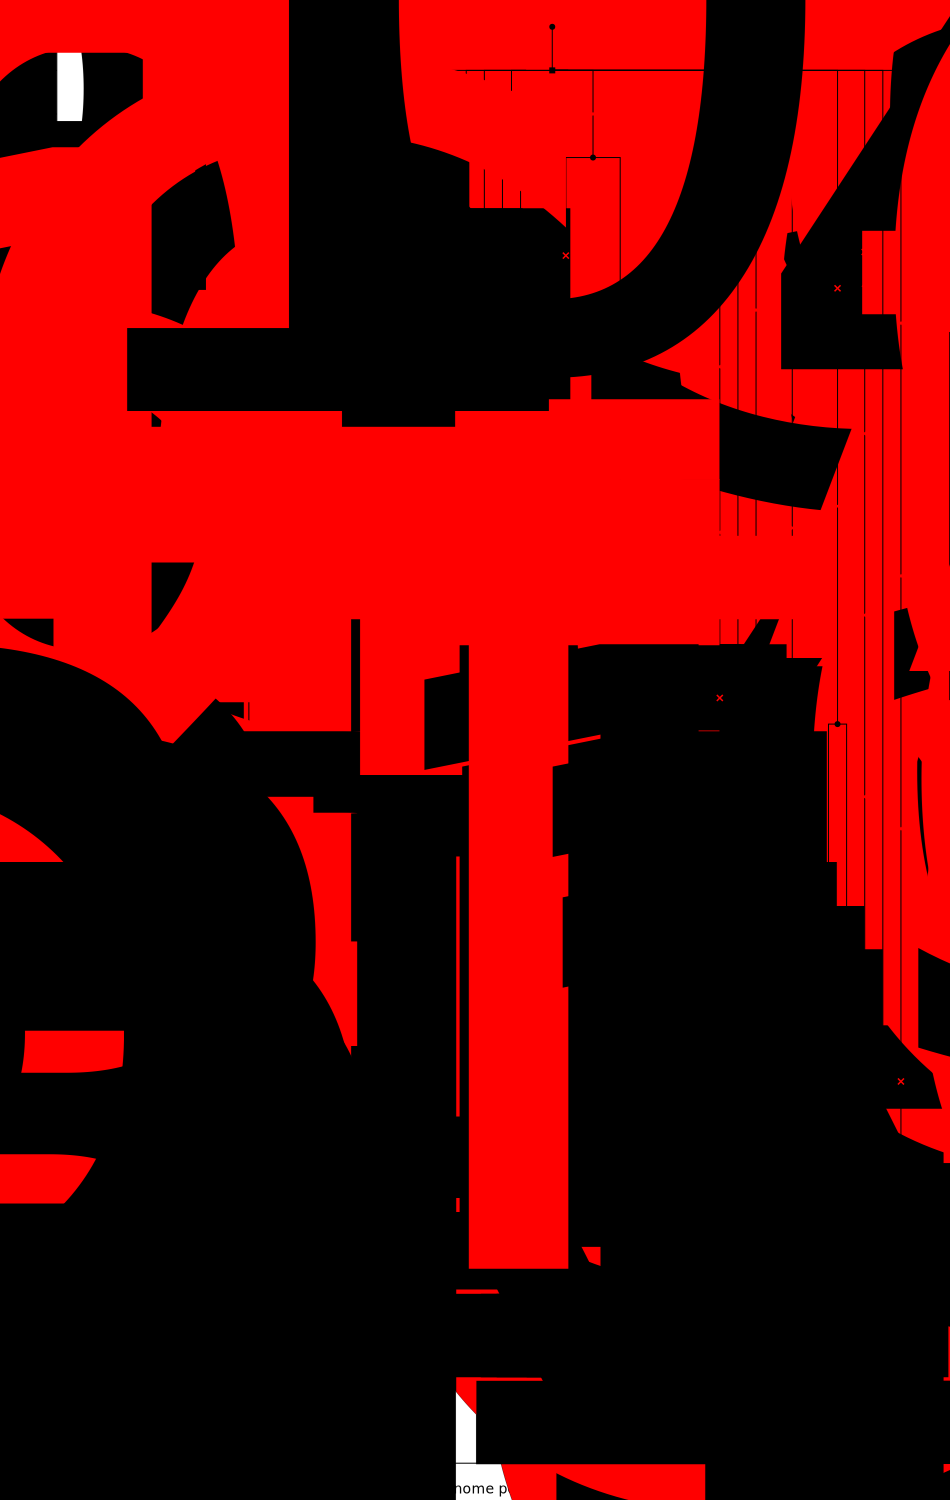

In [7]:
# Note that lineages A and B are characterised by differences at two site positions: 8782 and 28144.
# Lineage B samples have 8782C and 28144T, whereas lineage A samples have 8782T and 28144C.
# 
# The reference Wuhan-Hu-1 belongs to lineage B, and is arbitrarily chosen as the root here.
# So, we should expect to see samples from lineage A grouped by two mutations: C8782T and T28144C.
label_style = (
    ".mut > .lab {font-size: 80%; transform: rotate(-25deg) translate(0px)}"
    ".node > .lab {font-size: 80%}"
    ".leaf > .lab {text-anchor: middle; transform: rotate(-35deg) translateY(10px)}"
)

ts.draw_svg(
    node_labels=node_labels,
    mutation_labels=mut_labels,
    y_axis=True,
    time_scale="rank",
    x_scale="treewise",
    size=(950, 1500),
    style=label_style,
)


## Constructing a recombinant

Pick two samples with mutations on opposite sides of the sequence, and create a franken-haplotype

In [8]:
for u in [51, 36]:
    print(ts.node(u).metadata["strain"])

SRR11597163
SRR11597188


In [9]:
def mutations_on_path(u, v):
    tree = ts.first()
    mutations = []
    while u != v:
        for mut_id in np.where(ts.mutations_node == u)[0]:
            mut = ts.mutation(mut_id)
            pos = int(ts.sites_position[mut.site])
            mutations.append((pos, mut.derived_state))
        u = tree.parent(u)
    return sorted(mutations)
    

In [10]:
strains = ["SRR11597188", "SRR11597163"]
for strain in strains:
    u = ts.samples()[ts.metadata["sc2ts"]["samples_strain"].index(strain)]
    print(strain, u, mutations_on_path(u, 1), sep="\t")

SRR11597188	36	[(871, 'G'), (3027, 'G'), (3787, 'T')]
SRR11597163	51	[(15324, 'T'), (29303, 'T')]


# TreeInfo

In [11]:
ti = sc2ts.TreeInfo(ts)
ti

Classifying mutations: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:00<00:00, 93099.28it/s]


,value
property,
latest_sample,2020-02-13
samples,49
nodes,62
exact_matches,8
mc_nodes,4
pr_nodes,3
re_nodes,0
imr_nodes,0
mutations,77


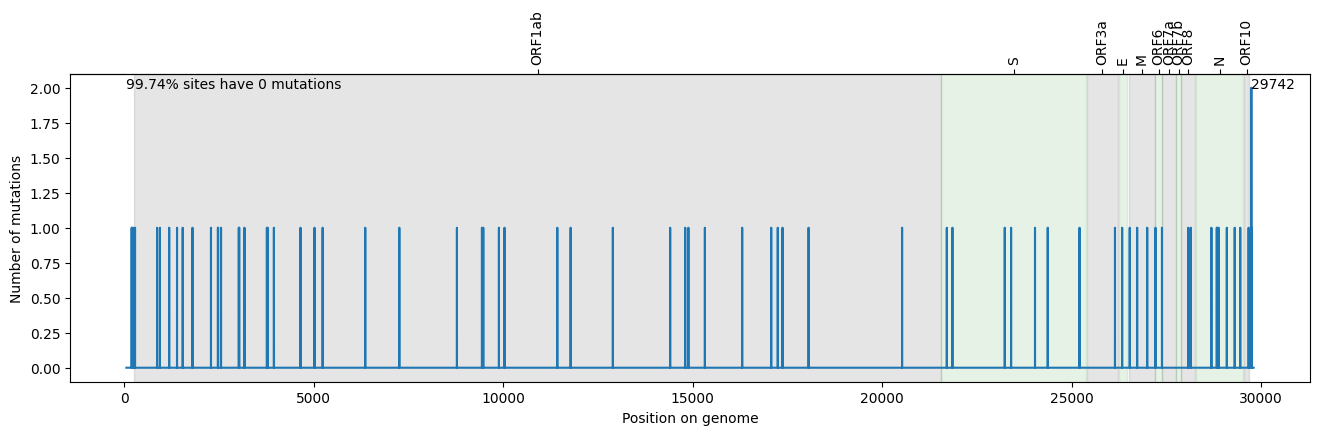

In [12]:
ti.plot_mutations_per_site()

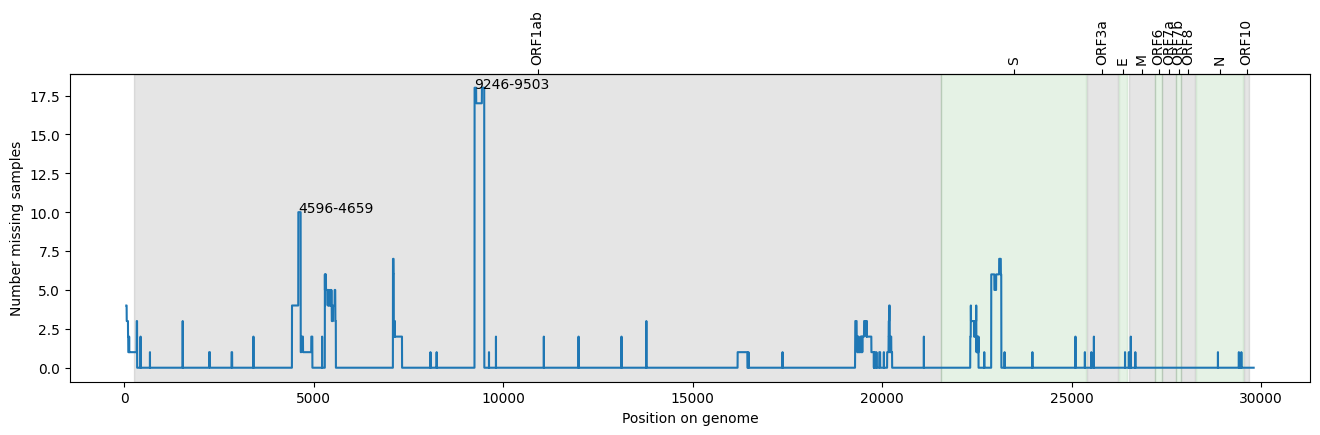

In [13]:
ti.plot_missing_samples_per_site()

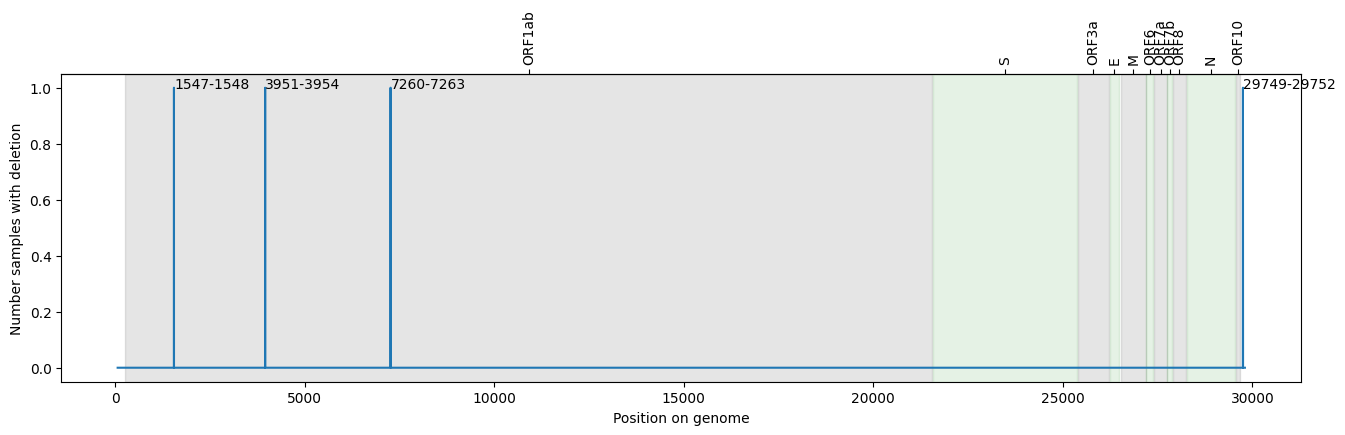

In [14]:
ti.plot_deletion_samples_per_site()

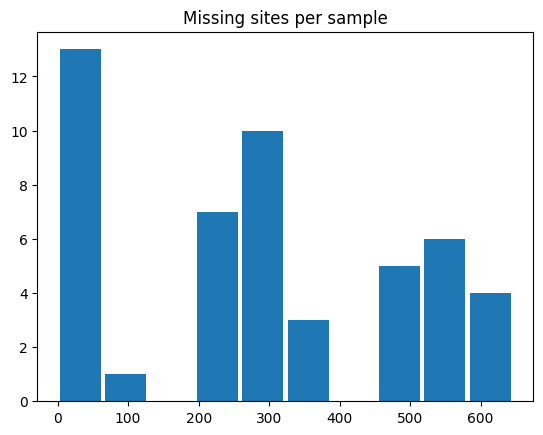

In [15]:
ti.plot_missing_sites_per_sample()

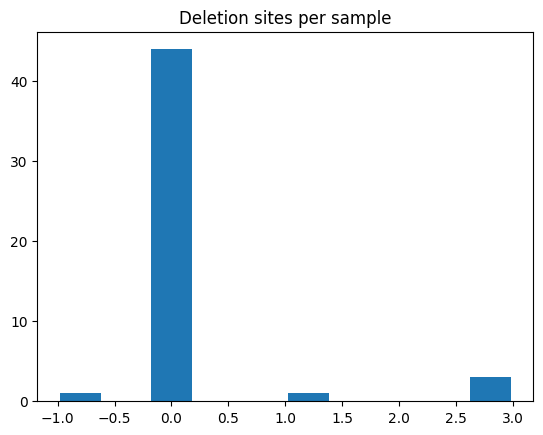

In [16]:
ti.plot_deletion_sites_per_sample()

# Deletions

We have 4 different deletion events: 1 bp at 1547, and 3 3p deletions at 2951, 7260 and 29750

In [17]:
ti.mutations_position[ti.mutations_derived_state == "-"]

array([ 1547,  3951,  3952,  3953,  7260,  7261,  7262, 29749, 29750,
       29751])

In [18]:
for u in ts.samples()[1:]:
    md = ti.nodes_metadata[u]
    if "-" in md["sc2ts"]["alignment_composition"]:
        md = ti.nodes_metadata[u]
        print(md["strain"], md["date"])
    #print(ti.nodes_metadata[u]["sc2ts"]["num_deletion_sites"])

SRR11597164 2020-02-02
SRR11597190 2020-02-02
SRR11597174 2020-02-04
SRR11597218 2020-02-11


# Missing data

In [19]:
for u in ts.samples()[1:]:
    md = ti.nodes_metadata[u]
    if md["sc2ts"]["num_missing_sites"] > 0:
        print(md["strain"], md["date"], md["sc2ts"]["num_missing_sites"] )
    #print(ti.nodes_metadata[u]["sc2ts"]["num_deletion_sites"])

SRR11397727 2020-01-24 560
SRR11397730 2020-01-24 535
SRR11397726 2020-01-25 276
SRR11397729 2020-01-25 547
SRR11597198 2020-01-25 254
SRR11597143 2020-01-28 254
SRR11597154 2020-01-28 492
SRR11597121 2020-01-29 254
SRR11597220 2020-01-29 505
SRR11597177 2020-01-30 484
SRR12162232 2020-01-30 300
SRR12162235 2020-01-30 345
SRR11494548 2020-01-31 514
SRR11597140 2020-02-01 320
SRR11597151 2020-02-01 228
SRR11597144 2020-02-01 331
SRR11597153 2020-02-01 65
SRR11597114 2020-02-02 278
SRR11597164 2020-02-02 1
SRR11597190 2020-02-02 2
SRR11597195 2020-02-02 317
ERR4239266 2020-02-03 532
SRR11597191 2020-02-03 1
SRR11597174 2020-02-04 314
SRR11597188 2020-02-04 254
SRR11597136 2020-02-04 646
SRR11597175 2020-02-04 279
SRR11597156 2020-02-05 340
SRR11597168 2020-02-06 593
SRR11597178 2020-02-06 500
SRR11597196 2020-02-06 254
SRR11597150 2020-02-07 254
SRR11397718 2020-02-08 292
SRR11397722 2020-02-08 276
SRR11597163 2020-02-08 317
ERR4206180 2020-02-09 546
SRR11597116 2020-02-10 617
SRR1159720

## Samples with one mutation

In [20]:
s = ts.samples()[ti.nodes_num_mutations[ts.samples()] == 1]
for u in s:
    md = ti.nodes_metadata[u]
    hmm = md["sc2ts"]["hmm_match"]
    muts = hmm["mutations"]
    if len(muts) == 1:
        print(md["strain"], hmm["path"][0]["parent"], muts)


SRR11597154 1 [{'derived_state': 'T', 'inherited_state': 'C', 'site_position': 24370}]
SRR11597151 9 [{'derived_state': 'A', 'inherited_state': 'T', 'site_position': 9477}]
SRR11597146 9 [{'derived_state': 'T', 'inherited_state': 'C', 'site_position': 29095}]
ERR4206593 54 [{'derived_state': 'T', 'inherited_state': 'C', 'site_position': 26994}]


In [21]:
ti.num_samples_per_day

array([3, 0, 2, 1, 2, 3, 2, 3, 1, 4, 2, 4, 4, 1, 5, 3, 2, 0, 0, 3, 2, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1])